In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/voting_VA.csv")

print(df.head())
print(df.isnull().sum())

   Unnamed: 0  year     state state_po county_name  county_fips        office  \
0       11161  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
1       11162  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
2       11163  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
3       11164  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
4       11165  2000  VIRGINIA       VA   ALBEMARLE        51003  US PRESIDENT   

        candidate       party  candidatevotes  totalvotes   version   mode  
0         AL GORE    DEMOCRAT            5092       11925  20220315  TOTAL  
1  GEORGE W. BUSH  REPUBLICAN            6352       11925  20220315  TOTAL  
2     RALPH NADER       GREEN             220       11925  20220315  TOTAL  
3           OTHER       OTHER             261       11925  20220315  TOTAL  
4         AL GORE    DEMOCRAT           16255       36846  20220315  TOTAL  
Unnamed: 0        0
year              0
state      

In [2]:
# Remove the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Check unique values for certain columns to ensure consistency
print(df['state'].unique())  # Should only contain "VIRGINIA"
print(df['state_po'].unique())  # Should only contain "VA"
print(df['office'].unique())  # Should only contain "US PRESIDENT"
print(df['mode'].unique())  # Check if any action is needed

['VIRGINIA']
['VA']
['US PRESIDENT']
['TOTAL' 'ABSENTEE' 'ELECTION DAY' 'PROVISIONAL']


In [3]:
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: object

In [4]:
# If we're interested in overall voting results without differentiating between the modes:
# df_total = df[df['mode'] == 'TOTAL']
# df_total.to_csv("data/clean_total_voting_VA.csv", index=False) 

# Otherwise, we can keep all of the modes of voting and use them as features
# in our models
df['mode'] = df['mode'].astype('category')
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: category
Categories (4, object): ['ABSENTEE', 'ELECTION DAY', 'PROVISIONAL', 'TOTAL']

In [5]:
# Provides a dataframe where the modes aggregates all individual records across different voting modes 
# into a single record per candidate per county per election year. 

df_aggregated = df.groupby(['year', 'county_name', 'county_fips', 'candidate', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'  # Assuming totalvotes is the same across all modes, otherwise sum might be needed
}).reset_index()

df_aggregated.head()

,year,county_name,county_fips,candidate,party,candidatevotes,totalvotes
0,2000,ACCOMACK,51001,AL GORE,DEMOCRAT,5092,11925
1,2000,ACCOMACK,51001,GEORGE W. BUSH,REPUBLICAN,6352,11925
2,2000,ACCOMACK,51001,OTHER,OTHER,261,11925
3,2000,ACCOMACK,51001,RALPH NADER,GREEN,220,11925
4,2000,ALBEMARLE,51003,AL GORE,DEMOCRAT,16255,36846


In [6]:
import pandas as pd
#removing candidates column (unimportant)
df_real = df_aggregated.drop('candidate', axis=1)
#removing third parties (also unimportant)
df_real = df_real[~df_real['party'].isin(['OTHER', 'GREEN'])]
#finding net total votes
df_real['net_total'] = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes'])['candidatevotes'].transform(lambda x: x.iloc[1] - x.iloc[0])

# merging columns
df_real = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes', 'net_total']).agg({'party': ', '.join}).reset_index()
df_real['winner'] = df_real['net_total'].apply(lambda x: 'REPUBLICAN' if x > 0 else 'DEMOCRAT')
#dropping some more columns
df_real = df_real.drop(['party', 'totalvotes'], axis=1)
df_final = df_real[['year', 'county_name', 'county_fips','net_total', 'winner']]
df_final.head()

,year,county_name,county_fips,net_total,winner
0,2000,ACCOMACK,51001,1260,REPUBLICAN
1,2000,ALBEMARLE,51003,2036,REPUBLICAN
2,2000,ALEXANDRIA,51510,-14590,DEMOCRAT
3,2000,ALLEGHANY,51005,594,REPUBLICAN
4,2000,AMELIA,51007,1193,REPUBLICAN


In [7]:
df_melt = pd.read_csv("data/df_melt.csv")

year_mapping = {
    2000: 2000,
    2004: 2000,
    2008: 125,
    2012: 125,
    2016: 195,
    2020: 195
}
df_final['melt_year'] = df_final['year'].map(year_mapping)

# Convert columns to the same data type before merging
df_final['melt_year'] = df_final['melt_year'].astype(str)
df_final['county_fips'] = df_final['county_fips'].astype(str)
df_melt['YEAR'] = df_melt['YEAR'].astype(str)
df_melt['FIPS'] = df_melt['FIPS'].astype(str)

merged_df = pd.merge(df_final, df_melt, left_on=['melt_year', 'county_fips'], right_on=['YEAR', 'FIPS'])

columns_to_drop = ['YEAR', 'FIPS', 'melt_year']
df_updated = merged_df.drop(columns=columns_to_drop)

print(df_updated.head())

   year county_name county_fips  net_total      winner     AV0AA     B78AA  \
0  2000    ACCOMACK       51001       1260  REPUBLICAN   38305.0   38305.0   
1  2004    ACCOMACK       51001      -2208    DEMOCRAT   38305.0   38305.0   
2  2000   ALBEMARLE       51003       2036  REPUBLICAN   79236.0   79236.0   
3  2004   ALBEMARLE       51003        899  REPUBLICAN   79236.0   79236.0   
4  2000  ALEXANDRIA       51510     -14590    DEMOCRAT  128283.0  128283.0   

     AV1AA    AV1AB    AT5AA  ...   A88AD    A88AE    AB2AA    BD5AA  \
0  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
1  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
2  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
3  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
4  61974.0  66309.0  95683.0  ...  6275.0  17685.0  67023.0  37645.0   

      AX6AA    CL6AA    AX7AA     AX7AB  BV8AA   BV8AB  
0   37715.0   6788.0   6788.0   30927.0  

In [8]:
df_updated = df_updated.drop(columns=['winner'])
df_updated = pd.get_dummies(df_updated, columns=['county_name'])
df_updated = df_updated.astype(float)


year                           0
county_fips                    0
net_total                      0
AV0AA                          1
B78AA                          1
                              ..
county_name_WINCHESTER         0
county_name_WINCHESTER CITY    0
county_name_WISE               0
county_name_WYTHE              0
county_name_YORK               0
Length: 330, dtype: int64


/tmp/ipykernel_210711/2591003917.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()  # Adjust subplots to fit into figure area.


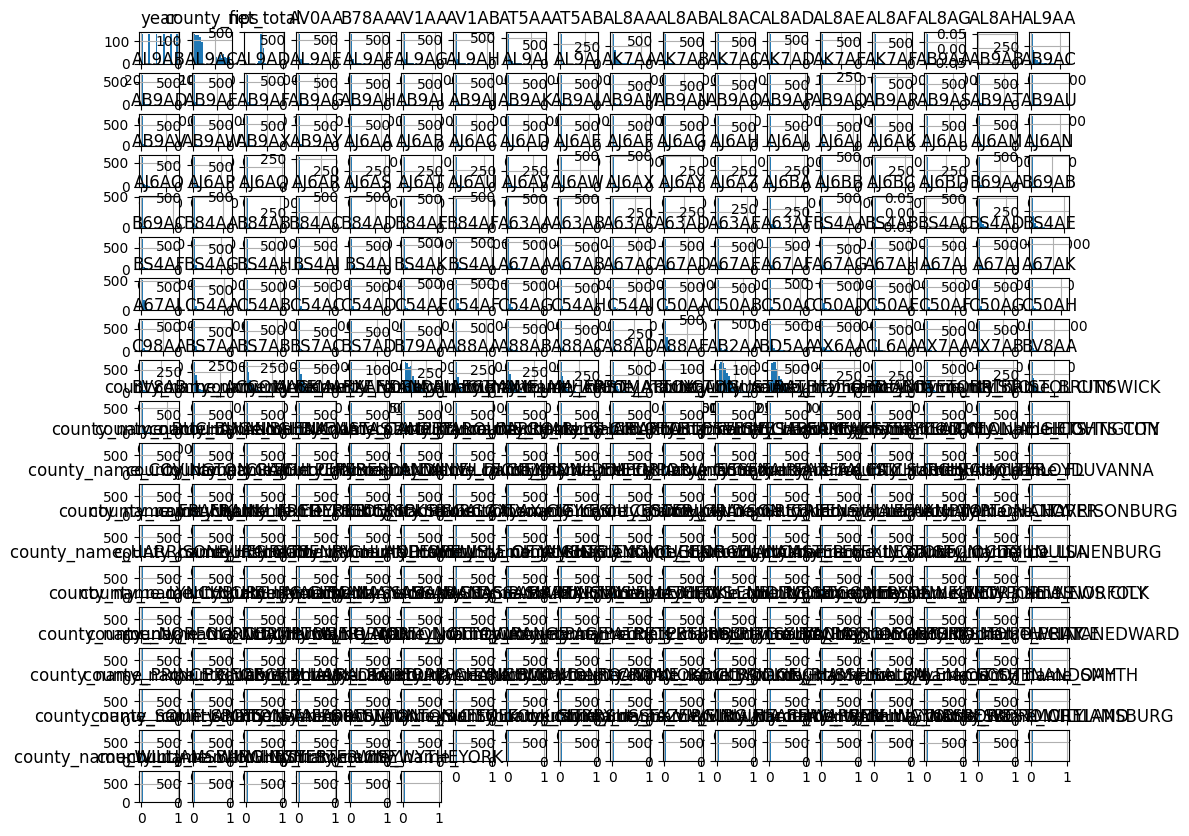

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


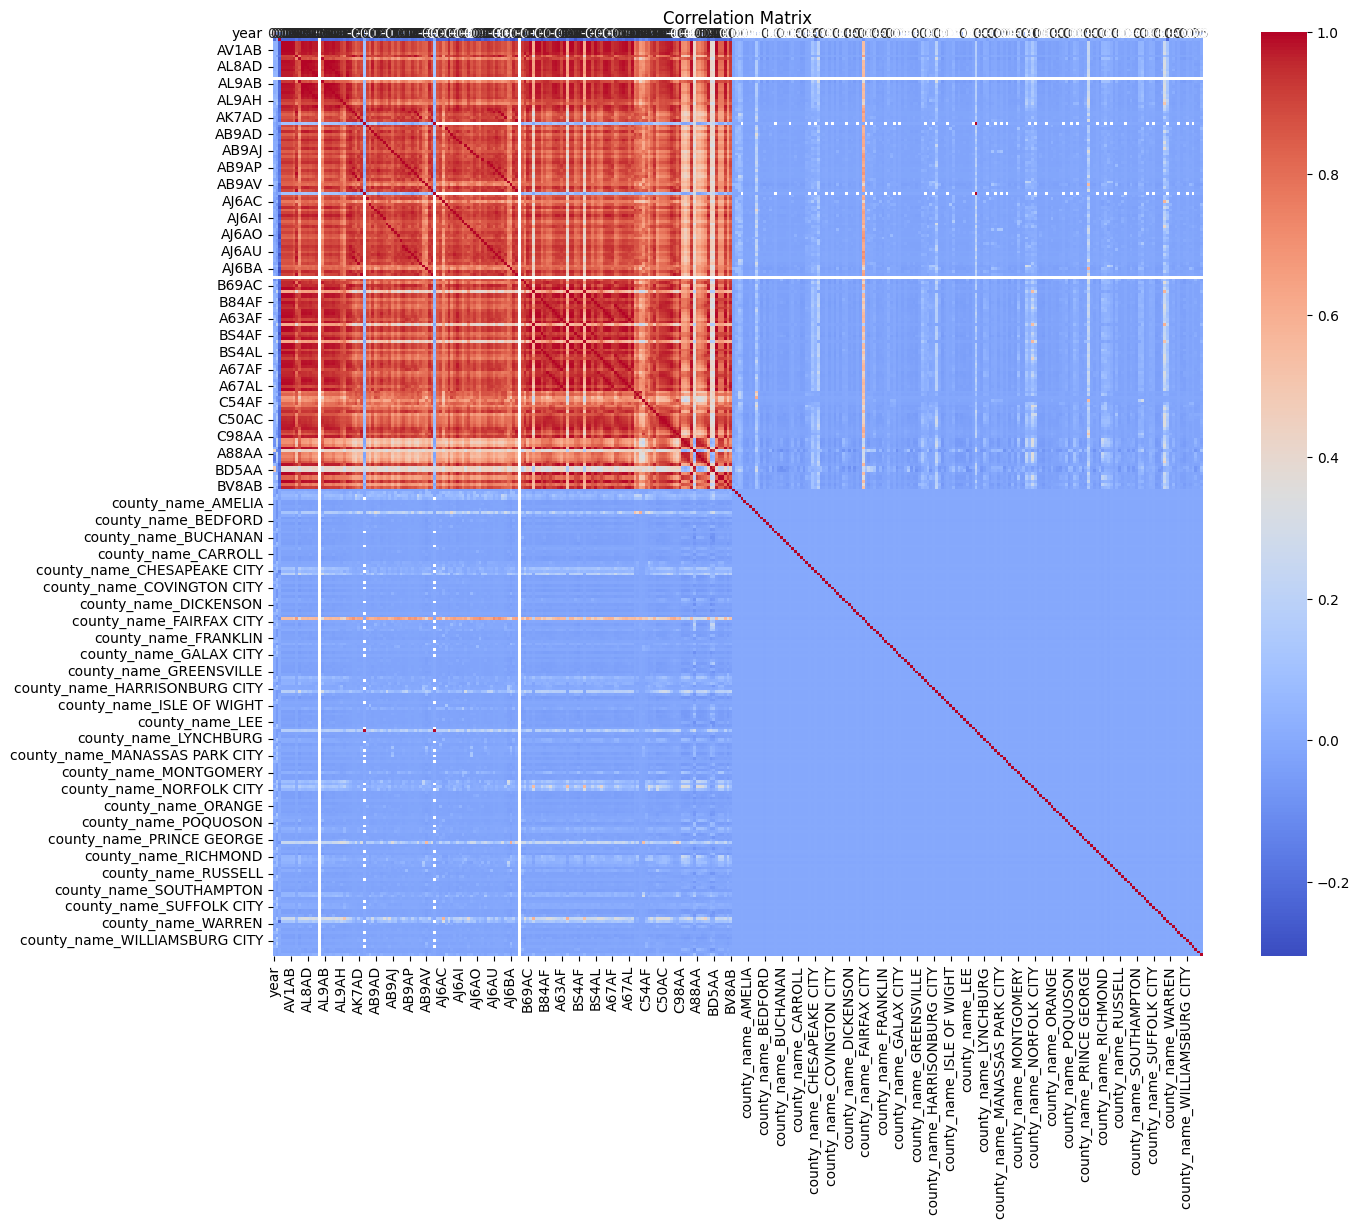

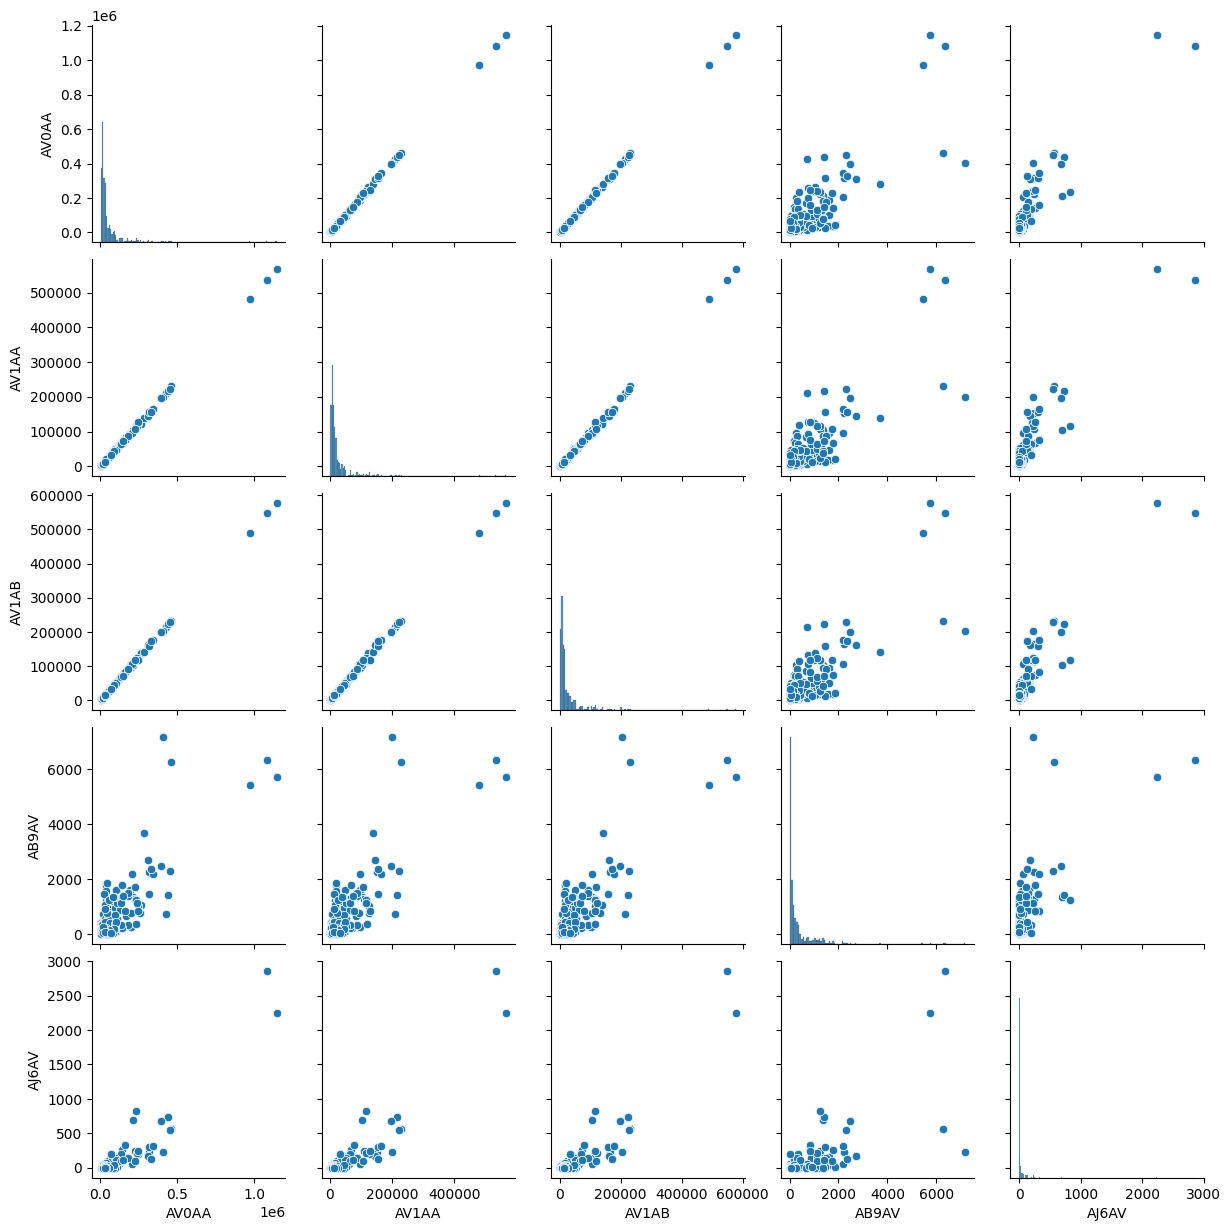

In [9]:
# EDA

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df_eda = df_updated.copy(deep=True)


# Check for missing values
print(df_eda.isnull().sum())

# Histograms for numeric data to understand distributions
df_eda.hist(figsize=(12, 10), bins=20)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

''' # Boxplots for numerical columns to visualize outliers
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
fig, ax = plt.subplots(len(numeric_cols), 1, figsize=(10, len(numeric_cols)*4))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(f'Boxplot for {col}', fontsize=12)
plt.tight_layout()
plt.show()
'''

# Correlation matrix to explore potential relationships
corr_matrix = df_eda.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Pairplot for selected features including the transformed net_total
selected_features = [col for col in df_eda.columns if 'AV' in col][:5]  # example with AV columns
sns.pairplot(df_eda[selected_features])
plt.show()


In [10]:
df_updated['net_total'] = np.arcsinh(df_updated['net_total'])
scaler = MinMaxScaler()

# Get the list of numeric columns excluding 'year', 'net_total' and 'county_fips'
numeric_cols = df_updated.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['year', 'county_fips', 'net_total']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

df_updated[numeric_cols] = scaler.fit_transform(df_updated[numeric_cols])

print(df_updated.head())

df_2020 = df_updated[df_updated['year'] == 2020]
df_total = df_updated[df_updated['year'] != 2020]
df_2020.reset_index(drop=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

     year  county_fips  net_total     AV0AA     B78AA     AV1AA     AV1AB  \
0  2000.0      51001.0   7.832014  0.031566  0.031566  0.030908  0.032214   
1  2004.0      51001.0  -8.392990  0.031566  0.031566  0.030908  0.032214   
2  2000.0      51003.0   8.311890  0.067356  0.067356  0.065137  0.069538   
3  2004.0      51003.0   7.494431  0.067356  0.067356  0.065137  0.069538   
4  2000.0      51510.0 -10.281239  0.110242  0.110242  0.107408  0.113030   

      AT5AA     AT5AB     AL8AA  ...  county_name_WAYNESBORO  \
0  0.043935  0.004512  0.067998  ...                     0.0   
1  0.043935  0.004512  0.067998  ...                     0.0   
2  0.090827  0.016016  0.121790  ...                     0.0   
3  0.090827  0.016016  0.121790  ...                     0.0   
4  0.119113  0.090837  0.085127  ...                     0.0   

   county_name_WAYNESBORO CITY  county_name_WESTMORELAND  \
0                          0.0                       0.0   
1                          0.0  

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [11]:
# Neural network time!
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split



y = df_total['net_total'].astype(float)
X = df_total.drop('net_total', axis=1).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

net = Sequential()
#Having 3 layers results in Loss: 218362592.0, Mean Absolute Error (MAE): 6693.912109375, Mean Squared Error (MSE): 218362592.0
net.add(Dense(units=82, activation='relu', input_dim=X_train.shape[1]))
#net.add(Dense(units=32, activation='relu'))
net.add(Dense(units=1, activation='linear'))

net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

net.fit(X_train, y_train, epochs=25, verbose=1, batch_size=50)

# use it to predict testing data
evaluation = net.evaluate(X_test, y_test)

# Extract the evaluation metrics
loss = evaluation[0]
mae = evaluation[1]
mse = evaluation[2]
print("Evaluation metrics:")
print(f"Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

2024-05-07 20:40:53.508212: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 20:40:54.223377: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 20:40:58.841865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/25
11/11 [==============================] - 1s 2ms/step - loss: 70.5888 - mae: 8.2507 - mse: 70.5888
Epoch 2/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5881 - mae: 8.2507 - mse: 70.5881
Epoch 3/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5872 - mae: 8.2506 - mse: 70.5872
Epoch 4/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5872 - mae: 8.2506 - mse: 70.5872
Epoch 5/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5866 - mae: 8.2505 - mse: 70.5866
Epoch 6/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5867 - mae: 8.2505 - mse: 70.5867
Epoch 7/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5859 - mae: 8.2504 - mse: 70.5859
Epoch 8/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5860 - mae: 8.2504 - mse: 70.5860
Epoch 9/25
11/11 [==============================] - 0s 1ms/step - loss: 70.5859 - mae: 8.2504 - mse: 70.5859
Epoch 10/25
11/11 [

In [12]:
# Then use it to predict data from 2020 election since it's closest to current election
test_2020 = df_2020.drop('net_total', axis=1)
print(test_2020.head())
predictions_2020 = net.predict(test_2020)

# Sum all the predictions
total_prediction = predictions_2020.sum()

# Check if the total prediction is positive, negative, or zero
if total_prediction > 0:
    print("R wins by "+ str(total_prediction))
elif total_prediction < 0:
    print("D wins by "+ str(total_prediction))
else:
    print("Cannot make a prediction.")

     year  county_fips     AV0AA     B78AA     AV1AA     AV1AB     AT5AA  \
0  2020.0      51001.0  0.026642  0.026642  0.026224  0.027052  0.035612   
1  2020.0      51003.0  0.091986  0.091986  0.088697  0.095222  0.119821   
2  2020.0      51510.0  0.135888  0.135888  0.132059  0.139654  0.143315   
3  2020.0      51005.0  0.011326  0.011326  0.011118  0.011531  0.016270   
4  2020.0      51007.0  0.009399  0.009399  0.009730  0.009073  0.013514   

      AT5AB     AL8AA     AL8AB  ...  county_name_WAYNESBORO  \
0  0.007020  0.054705  0.022307  ...                     0.0   
1  0.031105  0.155589  0.091887  ...                     0.0   
2  0.119643  0.103680  0.156921  ...                     0.0   
3  0.000513  0.032698  0.005539  ...                     0.0   
4  0.000399  0.028323  0.003785  ...                     0.0   

   county_name_WAYNESBORO CITY  county_name_WESTMORELAND  \
0                          0.0                       0.0   
1                          0.0        

In [13]:
#Then evaluate the actual accuracy of the prediction. 
evaluation_2020 = net.evaluate(df_2020.drop('net_total', axis=1), df_2020['net_total'])

# Extract the evaluation metrics
loss_2020 = evaluation_2020[0]
mae_2020 = evaluation_2020[1]
mse_2020 = evaluation_2020[2]
print("Evaluation metrics on 2020 data:")
print(f"Loss: {loss_2020}")
print(f"Mean Absolute Error (MAE): {mae_2020}")
print(f"Mean Squared Error (MSE): {mse_2020}")


5/5 [==============================] - 0s 1ms/step - loss: 94.9483 - mae: 9.6864 - mse: 94.9483
Evaluation metrics on 2020 data:
Loss: 94.9483413696289
Mean Absolute Error (MAE): 9.686424255371094
Mean Squared Error (MSE): 94.9483413696289


In [14]:
#Now for the linear regression:

In [15]:
import pandas as pd
df_lr = df_total.copy()
print(df_lr.isna().sum())

year                           0
county_fips                    0
net_total                      0
AV0AA                          1
B78AA                          1
                              ..
county_name_WINCHESTER         0
county_name_WINCHESTER CITY    0
county_name_WISE               0
county_name_WYTHE              0
county_name_YORK               0
Length: 330, dtype: int64


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

print(df_lr.head())

     year  county_fips  net_total     AV0AA     B78AA     AV1AA     AV1AB  \
0  2000.0      51001.0   7.832014  0.031566  0.031566  0.030908  0.032214   
1  2004.0      51001.0  -8.392990  0.031566  0.031566  0.030908  0.032214   
2  2000.0      51003.0   8.311890  0.067356  0.067356  0.065137  0.069538   
3  2004.0      51003.0   7.494431  0.067356  0.067356  0.065137  0.069538   
4  2000.0      51510.0 -10.281239  0.110242  0.110242  0.107408  0.113030   

      AT5AA     AT5AB     AL8AA  ...  county_name_WAYNESBORO  \
0  0.043935  0.004512  0.067998  ...                     0.0   
1  0.043935  0.004512  0.067998  ...                     0.0   
2  0.090827  0.016016  0.121790  ...                     0.0   
3  0.090827  0.016016  0.121790  ...                     0.0   
4  0.119113  0.090837  0.085127  ...                     0.0   

   county_name_WAYNESBORO CITY  county_name_WESTMORELAND  \
0                          0.0                       0.0   
1                          0.0  

In [17]:
for column in df_lr.columns:
    df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
df_lr.fillna(0, inplace=True)

/tmp/ipykernel_210711/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
/tmp/ipykernel_210711/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
/tmp/ipykernel_210711/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [18]:
# Assuming df_total is prepared with necessary preprocessing
y = df_lr['net_total'].astype(float)
X = df_lr.drop('net_total', axis=1).astype(float)

In [19]:
print(X.isna().sum())
print(y.isna().sum())

year                                             0
county_fips                                      0
AV0AA                                            0
B78AA                                            0
AV1AA                                            0
                                                ..
missing_indicator_county_name_WINCHESTER         0
missing_indicator_county_name_WINCHESTER CITY    0
missing_indicator_county_name_WISE               0
missing_indicator_county_name_WYTHE              0
missing_indicator_county_name_YORK               0
Length: 659, dtype: int64
0


In [20]:
imputer = SimpleImputer(strategy='median')
transformed_data = imputer.fit_transform(df_lr)
df_lr = pd.DataFrame(transformed_data, columns=df_lr.columns)

In [21]:
print(df_lr.head())

     year  county_fips  net_total     AV0AA     B78AA     AV1AA     AV1AB  \
0  2000.0      51001.0   7.832014  0.031566  0.031566  0.030908  0.032214   
1  2004.0      51001.0  -8.392990  0.031566  0.031566  0.030908  0.032214   
2  2000.0      51003.0   8.311890  0.067356  0.067356  0.065137  0.069538   
3  2004.0      51003.0   7.494431  0.067356  0.067356  0.065137  0.069538   
4  2000.0      51510.0 -10.281239  0.110242  0.110242  0.107408  0.113030   

      AT5AA     AT5AB     AL8AA  ...  \
0  0.043935  0.004512  0.067998  ...   
1  0.043935  0.004512  0.067998  ...   
2  0.090827  0.016016  0.121790  ...   
3  0.090827  0.016016  0.121790  ...   
4  0.119113  0.090837  0.085127  ...   

   missing_indicator_county_name_WAYNESBORO  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   missing_in

In [22]:
# Assuming df_total is prepared with necessary preprocessing
#y = df_lr[2].astype(float)
#X = df_lr.drop(2, axis=1).astype(float)

In [23]:
print(df_lr.isna().sum())

year                                             0
county_fips                                      0
net_total                                        0
AV0AA                                            0
B78AA                                            0
                                                ..
missing_indicator_county_name_WINCHESTER         0
missing_indicator_county_name_WINCHESTER CITY    0
missing_indicator_county_name_WISE               0
missing_indicator_county_name_WYTHE              0
missing_indicator_county_name_YORK               0
Length: 660, dtype: int64


In [24]:
df_lr_cleaned = df_lr.dropna()

In [25]:
print(df_lr.isna().sum())

year                                             0
county_fips                                      0
net_total                                        0
AV0AA                                            0
B78AA                                            0
                                                ..
missing_indicator_county_name_WINCHESTER         0
missing_indicator_county_name_WINCHESTER CITY    0
missing_indicator_county_name_WISE               0
missing_indicator_county_name_WYTHE              0
missing_indicator_county_name_YORK               0
Length: 660, dtype: int64


In [26]:
# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# the lr model
model = LinearRegression()

In [28]:
# fitting
model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = model.predict(X_test)

In [30]:
print("Model Prediction: " , y_pred)

Model Prediction:  [-6.41180981e+00 -5.60970856e+00 -1.04289956e+01 -7.94127740e+00
 -2.55734718e-01 -6.44994672e+00  2.47668975e+01 -2.14087804e+00
  6.51863627e+00  6.48997980e+00 -1.00059010e+01  5.88417278e+00
  1.28445286e+01 -3.52378833e+00 -8.85672992e+00 -9.47288023e-01
  2.75120683e-01 -1.22062260e+01 -1.31287837e+01 -2.02247797e+00
  3.60552196e-01  4.68503125e+00 -1.62395937e+00  7.01227871e+00
  4.13605205e-01  8.12202330e+00  1.39134170e+00 -2.56449837e+00
 -7.45179071e+00  4.33921949e+02 -3.92554378e+00 -5.61255748e+00
  2.50787163e+00  3.50551920e+00  7.76574073e-01  3.93240801e-01
  8.39299110e+00  1.23403182e+01  1.89174974e+00 -9.65678857e+00
 -1.62956245e+01  4.28046953e+01 -1.70243514e+01 -8.88367352e+00
 -4.03658900e+01 -1.60988844e+01 -4.83763889e-01 -6.61749579e+00
 -4.51272976e+00 -3.39650874e+00 -1.68219467e+01 -3.41432215e+00
  4.29134099e+02 -1.06224334e+01  1.43010569e+01  7.53584770e+00
  7.42833333e+00  6.35623249e+00  9.46749184e+00  1.72457880e+00
  2.85

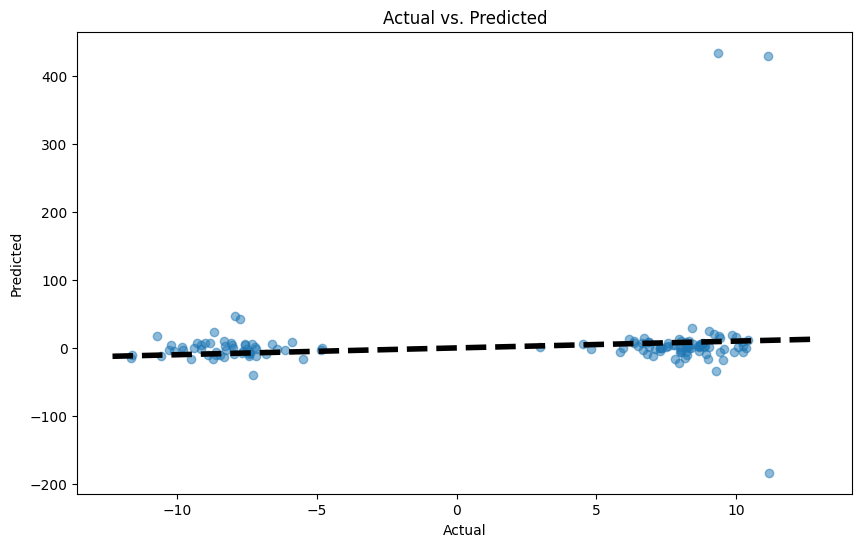

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [32]:
# evaluating model accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 3108.3692269161547
R^2 Score: -45.74740814318062


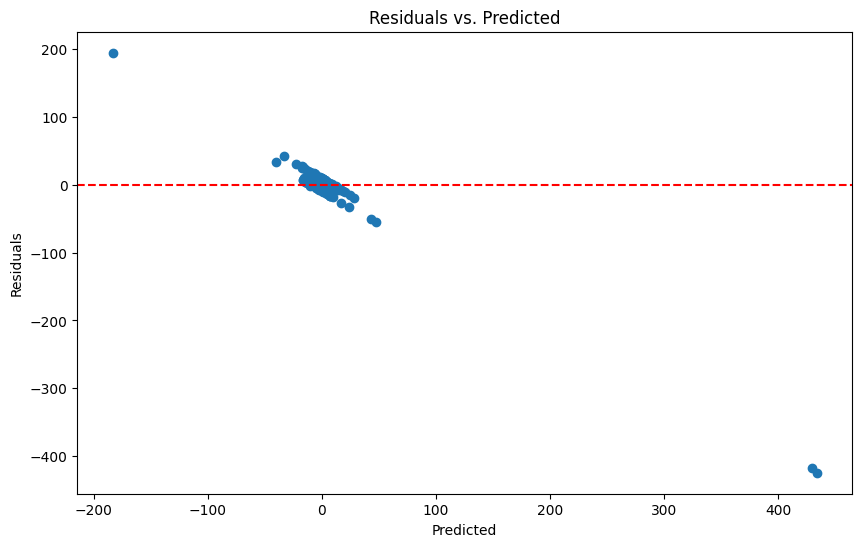

In [33]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

/tmp/ipykernel_210711/650600978.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


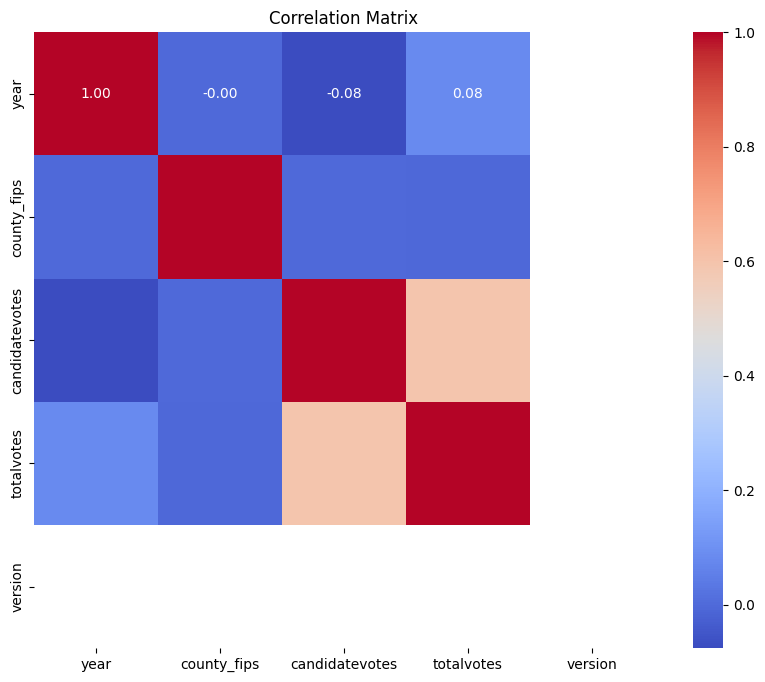

In [34]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Clearlt very poor results. This tells us we  have issues with data, where there are too many irrelevant or noisy features. There is also a lack of data scaling and normalization.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

model = RandomForestRegressor()
rf = model.fit(X_train,y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2) Score:", r2)
sns.scatterplot(x=y_test, y=y_hat_rf)

pred2020 = rf.predict(df_2020.drop('net_total', axis=1))

total_prediction = pred2020.sum()

if total_prediction > 0:
    print("R wins by "+ str(total_prediction))
elif total_prediction < 0:
    print("D wins by "+ str(total_prediction))
else:
    print("Cannot make a prediction.")

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2) Score:", r2)
sns.scatterplot(x=y_test, y=y_hat_rf)

Mean Squared Error (MSE): 27.12840420807006
R-squared (R^2) Score: 0.59201031434544


NameError: name 'y_hat_rf' is not defined